In [1]:
pip install gym==0.25.2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import valuenetwork
import experience_replay

In [ ]:
from valuenetwork import sqrt

In [ ]:
from google.colab import files

In [ ]:
import valuenetwork

In [ ]:
agent1= valuenetwork

In [ ]:
agent1.sqrt(4)

In [2]:
print("We will be using GPU if the device has a GPU")

We will be using GPU if the device has a GPU


In [ ]:
pip install "gym[atari, accept-rom-license]"

#GPU CODE

In [3]:
import gym
import torch
import torch.nn as nn
from itertools import count
from torch.distributions import Normal
import numpy as np
from collections import deque
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('ppoPendulum_logs')

/usr/local/lib/python3.9/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.9/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:38: DeprecationWarning: BICUBIC i

#Creating the policy network

In [5]:
env = gym.make('Pendulum-v1')
env.reset()
num_of_ations = env.action_space
num_of_actions=np.array(num_of_ations)
num_of_actions.size
print(env.observation_space.shape[0])
state_space = env.observation_space.shape[0]
print(state_space)
hidden_layer1= 64
hidden_layer2= 256

3
3


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
class PPOPolicyNetwork(nn.Module):
    def __init__(self):
        super(PPOPolicyNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(state_space, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc_mu = nn.Linear(hidden_layer2, 1)
        self.fc_std = nn.Linear(hidden_layer2, 1)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, state):
        state = self.relu(self.fc1(state))
        state = self.relu(self.fc2(state))
        out = 2 * self.tanh(self.fc_mu(state))
        std_dev = self.softplus(self.fc_std(state)) + 1e-3
        return out, std_dev

    def action_select(self, state):
        with torch.no_grad():
            out, std_dev = self.forward(state)
            norm = Normal(out, std_dev)
            action = norm.sample()
        return np.clip(action.item(), -2., 2.)


class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(state_space, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, 1)

    def forward(self, state):
        state = self.relu(self.fc1(state))
        state = self.relu(self.fc2(state))
        state = self.fc3(state)
        return state

In [7]:
env = gym.make('Pendulum-v1')
policy = PPOPolicyNetwork().to(device)
old_policy = PPOPolicyNetwork().to(device)
optim = torch.optim.Adam(policy.parameters(), lr=1e-5)
value = ValueNetwork().to(device)
value_optim = torch.optim.Adam(value.parameters(), lr=2e-5)
gamma = 0.9
steps = 0

is_learn = False

In [ ]:
for ep in count():
    state = env.reset()
    ep_reward = 0
    rewards = []
    states = []
    actions = []
    total_reward_for_graph=[]
    for time_steps in range(200):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = policy.action_select(state_tensor)
        next_state, reward, done, _ = env.step([action])
        ep_reward += reward
        total_reward_for_graph.append(ep_reward)
        reward = (reward + 8.1) / 8.1

        rewards.append(reward)
        states.append(state)
        actions.append(action)

        state = next_state

        if (time_steps+1) % 32 == 0 or time_steps == 199:
            old_policy.load_state_dict(policy.state_dict())
            with torch.no_grad():
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                R = value(next_state_tensor)
            for i in reversed(range(len(rewards))):
                R = gamma * R + rewards[i]
                rewards[i] = R
            rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)
            for K in range(10):
                steps += 1
                state_tensor = torch.FloatTensor(states).to(device)
                action_tensor = torch.FloatTensor(actions).unsqueeze(1).to(device)
                with torch.no_grad():
                    advantage = rewards_tensor - value(state_tensor)

                with torch.no_grad():
                    old_out, old_std_dev = old_policy(state_tensor)
                    old_norm = Normal(old_out, old_std_dev)
               
                out, std_dev= policy(state_tensor)
                
                norm = Normal(out, std_dev)
                log_prob = norm.log_prob(action_tensor)
                old_log_prob = old_norm.log_prob(action_tensor)
                ratio = torch.exp(log_prob - old_log_prob)
               
                L1 = ratio * advantage
                L2 = torch.clamp(ratio, 0.8, 1.2) * advantage
               
                loss = torch.min(L1, L2)
                loss = - loss.mean()
                
                
                optim.zero_grad()
                loss.backward()
                optim.step()

                value_loss = F.mse_loss(rewards_tensor, value(state_tensor))
                value_optim.zero_grad()
                value_loss.backward()
                value_optim.step()
            rewards = []
            states = []
            actions = []
    writer.add_scalar('episode reward', ep_reward, ep)
    if ep % 10 == 0:
        print('Episode number:{}, episode reward is {}'.format(ep, ep_reward))
        torch.save(policy.state_dict(), 'ppo-policy_for_pend.para')

/tmp/ipykernel_3242/1575866667.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state_tensor = torch.FloatTensor(states).to(device)


Episode number:0, episode reward is -1218.1000153185614
Episode number:10, episode reward is -1419.519548661467
Episode number:20, episode reward is -1132.4515411039733
Episode number:30, episode reward is -1179.0698107561045
Episode number:40, episode reward is -1479.862695721372
Episode number:50, episode reward is -1491.0705469904706
Episode number:60, episode reward is -1739.8063963580655
Episode number:70, episode reward is -1198.6253045726291
Episode number:80, episode reward is -1019.5810267323614
Episode number:90, episode reward is -1619.0784393300328
Episode number:100, episode reward is -1108.7041430069073
Episode number:110, episode reward is -1605.2760106572596
Episode number:120, episode reward is -1188.8014616468836
Episode number:130, episode reward is -750.6670077548063
Episode number:140, episode reward is -1033.1746531540368
Episode number:150, episode reward is -974.1299381216464
Episode number:160, episode reward is -1199.2097228216626
Episode number:170, episode r

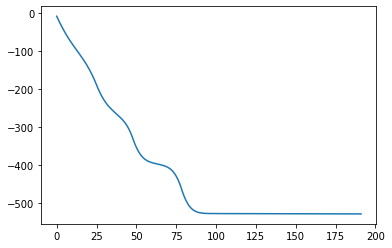

In [32]:
plt.plot(total_reward_for_graph)